### Importação das bibliotecas

In [1]:
import pandas as pd
import spacy

import collections
from collections import Counter

import re
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from unidecode import unidecode
import numpy as np

import nltk

In [3]:
from gensim.utils import simple_preprocess

In [4]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification,
    AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, AutoModel,
    BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
)
from bertopic import BERTopic
from bertopic.representation import PartOfSpeech, KeyBERTInspired
from bertopic.cluster import BaseCluster
from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [5]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#### União dos Dados

In [6]:
df_reviews = pd.read_csv("B2W-Reviews.csv", low_memory=False)

# comments = open('comments/comments_grand_hyatt_sao_paulo.txt', 'r', encoding='utf8') 

In [7]:
df_reviews.rename(columns={'Review': 'review_text'}, inplace=True)

In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)


In [9]:
most_frequent_product_name = df_reviews['product_name'].value_counts().idxmax()
product_df = df_reviews.loc[df_reviews['product_name'] == most_frequent_product_name]

In [10]:
most_frequent_product_name

'Smartphone Motorola Moto G 5S Dual Chip Android 7.1.1 Nougat Tela 5.2" Snapdragon 430 32GB 4G Câmera 16MP - Platinum'

In [11]:
columns_to_drop = ['submission_date', 'reviewer_id', 'product_id', 'site_category_lv1', 'site_category_lv2', 'overall_rating', 'product_brand', 'recommend_to_a_friend', 'review_title', 'reviewer_birth_year', 'reviewer_gender', 'reviewer_state']
df = product_df.drop(columns=columns_to_drop)
df = df.reset_index(drop=True)

# df.rename(columns={'review_text': 'review_text'}, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  792 non-null    object
 1   review_text   788 non-null    object
dtypes: object(2)
memory usage: 12.5+ KB


In [22]:
df['review_text'] = df['review_text'].astype(str)

In [24]:
# comments_data = comments.readlines()
# comments.close()
# df_reviews = pd.DataFrame(columns=['review_text'])
# comments_list = [comment.strip() for comment in comments_data]
# df_reviews['review_text'] = comments_list
# df_reviews.info()

In [ ]:
# dataset_names = df_reviews["dataset"].unique()

In [ ]:
# df_olist = df_reviews[df_reviews['dataset'] == 'olist']
# df_olist = df_olist[['review_text','rating']]
# df_olist.info()

In [ ]:
# merged_df = pd.concat([df_buscape, df_olist, df_b2w])
# df_olist = df_olist.dropna()
# df_olist = df_olist.drop_duplicates()
# df_olist = df_olist.reset_index(drop=True)
# df_olist.info()

#### Limpeza dos Dados

In [25]:
nltk.download(["stopwords", "rslp"])

PT_STOPWORDS = nltk.corpus.stopwords.words('portuguese')

REGEX = [
    {'input': r'/\d+/g', 'output': r' '},               # removing digits
    {'input': r'[^\w\s]', 'output': r' '},              # removing punctuationon
    {'input': r'\n', 'output': r' '},                   # removing line breaks
    {'input': r'\b\w{1,2}\b', 'output': r''},           # removing short words (1 or 2 characters)
]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [26]:
def regex_treatment(text):
    for pattern in REGEX:
        text = re.sub(pattern['input'], pattern['output'], text)
    return text.strip().lower()

def remove_stopwords(text):
    words = simple_preprocess(text)
    phrase_adjusted = " ".join([word for word in words if word not in PT_STOPWORDS])
    return phrase_adjusted.lower()

spacy_lemma = spacy.load("pt_core_news_md")

# Ignoring VERBs, ADVs, ADJs, PROPNs (...)
def lemmatizer(text, postags_permit=['NOUN']):
    """https://spacy.io/api/annotation"""
    doc = spacy_lemma(text.lower())
    doc_lemma = " ".join([token.lemma_ for token in doc if token.pos_ in postags_permit])
    return doc_lemma

def remove_accentuation(text):
    return unidecode(text)

Para a análise de tópicos utilizamos os 4 métodos de limpeza de dados.

In [10]:
df = df_reviews.copy()

In [27]:
df["review_text_topic"] = df["review_text"].apply(regex_treatment)
df["review_text_topic"] = df["review_text_topic"].apply(remove_stopwords)
df["review_text_topic"] = df["review_text_topic"].apply(lemmatizer)
df["review_text_topic"] = df["review_text_topic"].apply(remove_accentuation)

In [28]:
df["review_text_sentiment"] = df["review_text"].apply(regex_treatment)
df["review_text_sentiment"] = df["review_text_sentiment"].apply(remove_accentuation)

In [29]:
df = df.dropna(subset=['review_text_topic'])
df = df.reset_index(drop=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_name           792 non-null    object
 1   review_text            792 non-null    object
 2   review_text_topic      792 non-null    object
 3   review_text_sentiment  792 non-null    object
dtypes: object(4)
memory usage: 24.9+ KB


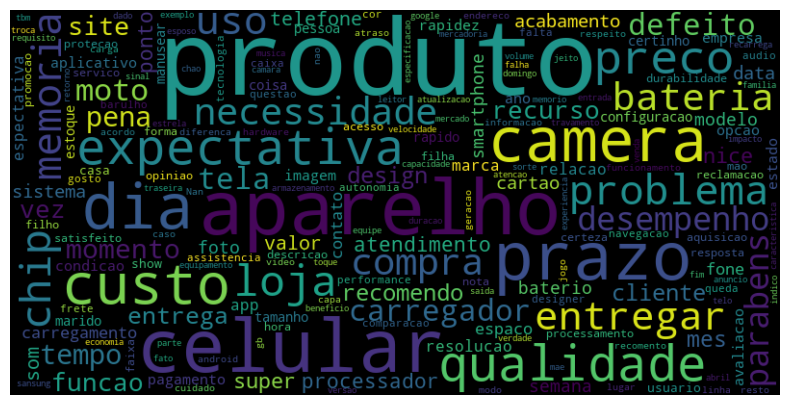

In [31]:
wordcloud_text = ' '.join(df["review_text_topic"].astype(str))

wordcloud = WordCloud(width=800, height=400, random_state=15, max_font_size=110, max_words=200, collocations=False).generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [32]:
df_comments = df["review_text_topic"]
doc_comments = df_comments.to_list()
doc_comments[:5]

['produto qualidade camera desenvolvimento rapidez',
 'produto funcao',
 'tempo prazo celular bateria dia',
 'produto design manusear',
 'tarde aparelho problema camera verdade camera produto']

### Análise de Tópicos

O algoritmo do BERTopic contém cinco etapas independentes até alcançar e criar as representações dos tópicos dos documentos: ```embedding```, ```redução de dimensionalidade```, ```clusterização```, ```tokenização``` e ```esquema de ponderação```. Ademais, por serem etapas independentes, o BERTopic permite que você monte sua própria modelagem de tópicos com as especificações de sua preferência.

Criação das embeddings (representações vetoriais) dos documentos textuais dos comentários utilizando o modelo pré-treinado ```paraphrase-multilingual-MiniLM-L12-v2```. Tal modelo foi escolhido com base em um código disponibilizado pela equipe responsável pelo BERTopic.

In [33]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(doc_comments, show_progress_bar=True, batch_size=128)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [34]:
with open('embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

embeddings = np.load('embeddings.npy')

Criação de um vocabulário limitado a palavras que aparecem pelo menos 100 vezes nos documentos fornecidos. Dessa forma, podemos descartar palavras "raras" que não irão contribuir significativamente para a aprendizagem do modelo.

In [35]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()

for doc in tqdm(doc_comments):
  vocab.update(tokenizer(doc))

vocab = [word for word, frequency in vocab.items() if frequency >= 100]

100%|██████████| 792/792 [00:00<00:00, 263391.12it/s]


Utilização da técnica UMAP (Uniform Manifold Approximation and Projection) para redução da dimensionalidade dos embeddings gerados anteriormente.

In [36]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=1711905, verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_components=10, n_jobs=1, random_state=1711905, verbose=True)
Thu May  9 18:56:51 2024 Construct fuzzy simplicial set
Thu May  9 18:56:53 2024 Finding Nearest Neighbors
Thu May  9 18:56:58 2024 Finished Nearest Neighbor Search
Thu May  9 18:57:01 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu May  9 18:57:03 2024 Finished embedding


In [37]:
with open('reduced_embeddings.npy', 'wb') as f:
    np.save(f, reduced_embeddings)

reduced_embeddings = np.load('reduced_embeddings.npy')

Utilização do algoritmo HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) para realizar a clusterização dos embeddings reduzidos gerados pelo modelo do UMAP.

In [71]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

hdbscan_model = HDBSCAN(min_samples=15, min_cluster_size=130, prediction_data=False)
clusters = hdbscan_model.fit(reduced_embeddings).labels_

# guacamole hyatt, 100
# motorola, 130

Construção de um modelo BERTopic personalizado, utilizando embeddings BERT, uma redução de dimensionalidade (UMAP), e um algoritmo de clustering (HDBSCAN) com diferentes modelos para vetorização e representação. 

In [72]:
class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings

embedding_model       = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')
umap_model            = Dimensionality(reduced_embeddings)
hdbscan_model         = BaseCluster()
vectorizer_model      = CountVectorizer(vocabulary=vocab, stop_words=PT_STOPWORDS, lowercase=True)
representation_model  = KeyBERTInspired()

topic_model = BERTopic(
  nr_topics               = "auto",
  top_n_words             = 10,
  embedding_model         = embedding_model,
  umap_model              = umap_model,
  hdbscan_model           = hdbscan_model,
  vectorizer_model        = vectorizer_model,
  representation_model    = representation_model,
  verbose                 = True
).fit(doc_comments, embeddings=embeddings, y=clusters)

2024-05-09 18:59:54,417 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-09 18:59:54,417 - BERTopic - Dimensionality - Completed ✓
2024-05-09 18:59:54,417 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-09 18:59:54,426 - BERTopic - Cluster - Completed ✓
2024-05-09 18:59:54,426 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-09 18:59:54,913 - BERTopic - Representation - Completed ✓
2024-05-09 18:59:54,913 - BERTopic - Topic reduction - Reducing number of topics
2024-05-09 18:59:55,128 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


In [73]:
freq = topic_model.get_topic_info()
freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,0,513,0_produto_prazo_aparelho_dia,"[produto, prazo, aparelho, dia, camera, celula...","[produto atendimento produto condicao prazo, p..."
1,1,279,1_celular_camera_aparelho_produto,"[celular, camera, aparelho, produto, , , , , , ]","[celular camera video telefone, celular necess..."


In [74]:
topic_model.get_topic_freq().head(5)

,Topic,Count
1,0,513
0,1,279


In [75]:
topic_model.get_topic(0)

[('produto', 0.5815523),
 ('prazo', 0.4405504),
 ('aparelho', 0.1568595),
 ('dia', 0.108938314),
 ('camera', 0.07238525),
 ('celular', 0.06567275),
 ('', 0.03450574),
 ('', 0.03450574),
 ('', 0.03450574),
 ('', 0.03450574)]

In [76]:
topic_model.get_topic(1)

[('celular', 0.68748057),
 ('camera', 0.6593984),
 ('aparelho', 0.36857295),
 ('produto', 0.2416237),
 ('', 0.122100055),
 ('', 0.122100055),
 ('', 0.122100055),
 ('', 0.122100055),
 ('', 0.122100055),
 ('', 0.122100055)]

In [77]:
topic_model.get_topic(2)

False

In [78]:
topic_model.get_topic(3)

False

In [79]:
topic_model.visualize_barchart(top_n_topics=8)

#### DataFrame com informações completas

In [80]:
df_topics = topic_model.get_document_info(doc_comments)

In [81]:
df_complete_topic_info = df.copy()
df_complete_topic_info["topic"] = df_topics["Topic"]

In [82]:
df_complete_topic_info.head()

,product_name,review_text,review_text_topic,review_text_sentiment,topic
0,Smartphone Motorola Moto G 5S Dual Chip Androi...,Produto excelente qualidade boa câmera desenvo...,produto qualidade camera desenvolvimento rapidez,produto excelente qualidade boa camera desenvo...,1
1,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Produto excelente, ótimas funções, rápido, vis...",produto funcao,produto excelente otimas funcoes rapido vis...,0
2,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Nada mal, tempo de entrega antes do prazo. Sob...",tempo prazo celular bateria dia,nada mal tempo entrega antes prazo sobre ...,1
3,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Excelente produto, belo design, fácil de manus...",produto design manusear,excelente produto belo design facil manusea...,0
4,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Boa tarde. Estou insatisfeita com o aparelho, ...",tarde aparelho problema camera verdade camera ...,boa tarde estou insatisfeita com aparelho ...,1


### Análise de Sentimentos

In [83]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
DEVICE = torch.device('cpu')
class_names = ['negative', 'neutral', 'positive']

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin', map_location=DEVICE))
model = model.to(DEVICE)

In [84]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def predict_sentiment(text):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(DEVICE)
    attention_mask = encoded_review['attention_mask'].to(DEVICE)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    _, prediction = torch.max(output, dim=1)
    
    return class_names[prediction]

In [85]:
df_complete_topic_info["sentiment"] = df_complete_topic_info["review_text_sentiment"].apply(predict_sentiment)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [86]:
sentiment_counts = df_complete_topic_info.groupby(['topic', 'sentiment']).size().reset_index(name='count')

In [87]:
sentiment_counts 

,topic,sentiment,count
0,0,negative,55
1,0,neutral,20
2,0,positive,438
3,1,negative,31
4,1,neutral,20
5,1,positive,228


In [88]:
sentiment_counts_filt_0 = sentiment_counts.loc[sentiment_counts['topic'] == 0]
sentiment_counts_filt_0

,topic,sentiment,count
0,0,negative,55
1,0,neutral,20
2,0,positive,438


In [89]:
sentiment_counts_filt_1 = sentiment_counts.loc[sentiment_counts['topic'] == 1]
sentiment_counts_filt_1

,topic,sentiment,count
3,1,negative,31
4,1,neutral,20
5,1,positive,228


In [90]:
sentiment_counts_filt_2 = sentiment_counts.loc[sentiment_counts['topic'] == 2]
sentiment_counts_filt_2

,topic,sentiment,count


In [91]:
sentiment_counts_filt_3 = sentiment_counts.loc[sentiment_counts['topic'] == 3]
sentiment_counts_filt_3

,topic,sentiment,count


In [92]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, XLMRobertaForTokenClassification, pipeline, DistilBertTokenizerFast, BertForTokenClassification

MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

tokenizer_ner = AutoTokenizer.from_pretrained("51la5/roberta-large-NER", model_max_length=512)
model_ner = XLMRobertaForTokenClassification.from_pretrained("51la5/roberta-large-NER")
ner_task = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner)

Some weights of the model checkpoint at 51la5/roberta-large-NER were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [93]:
def extract_entities(df):
    all_entities = []

    for comment in df["review_text_sentiment"]:
        predictions = ner_task(comment)
        comment_entities = []

        if predictions != []:
            combined_word = ""
            previous_entity = None

            for prediction in predictions:
                entity = prediction['entity']
                word = prediction['word']

                if not word.startswith('▁'):
                    combined_word += word
                else:
                    if combined_word:
                        comment_entities.append((combined_word, previous_entity))
                    combined_word = word

                previous_entity = entity

            if combined_word:
                comment_entities.append((combined_word, previous_entity))

        all_entities.append(comment_entities)

    df_copy = df.copy()
    df_copy["token_predictions"] = all_entities

    return df_copy

In [94]:
df_ner = df_complete_topic_info.copy()
df_ner["token_predictions"] = ""

In [95]:
%%time

df_ner = extract_entities(df_ner)

CPU times: total: 18min 1s
Wall time: 3min 37s


In [96]:
count_unique = df_ner['token_predictions'].explode().value_counts()
count_unique

token_predictions
(▁motorola, I-ORG)            27
(▁americanas, I-ORG)          20
(▁motorola, I-MISC)           20
(▁moto, I-MISC)               18
(▁g5s, I-MISC)                15
(▁americana, I-MISC)          10
(▁android, I-MISC)             7
(▁lenovo, I-ORG)               6
(▁plus, I-MISC)                5
(▁samsung, I-ORG)              3
(▁asus, I-ORG)                 2
(▁americana, I-ORG)            2
(▁google, I-ORG)               2
(▁lenovo, I-MISC)              2
(▁asus, I-MISC)                2
(▁americana, I-LOC)            2
(▁motog, I-MISC)               2
(▁g5, I-MISC)                  2
(▁ios, I-MISC)                 2
(ola, I-MISC)                  1
(▁gs2, I-MISC)                 1
(▁correios, I-ORG)             1
(▁americas, I-ORG)             1
(▁gs5, I-MISC)                 1
(▁v300, I-MISC)                1
(▁tbm, I-ORG)                  1
(▁dia, I-MISC)                 1
(▁minas, I-LOC)                1
(▁gerais, I-LOC)               1
(▁rio, I-LOC)            

In [97]:
def entidade_mais_frequente_por_topico(df):
    entidade_por_topico = {'topic': [], 'entidades_mais_frequentes': [], 'frequencias': []}

    grupos = df.groupby('topic')

    for nome_grupo, grupo in grupos:
        contagem_entidades = {}

        for index, row in grupo.iterrows():
            for token_pred in row['token_predictions']:
                entidade = token_pred[0]
                contagem_entidades[entidade] = contagem_entidades.get(entidade, 0) + 1
        
        entidades_mais_frequentes = sorted(contagem_entidades, key=contagem_entidades.get, reverse=True)[:10]
        frequencias = [contagem_entidades[entidade] for entidade in entidades_mais_frequentes]

        entidades_string = ', '.join(entidades_mais_frequentes)
        frequencias_string = ', '.join(map(str, frequencias))

        entidade_por_topico['topic'].append(nome_grupo)
        entidade_por_topico['entidades_mais_frequentes'].append(entidades_string)
        entidade_por_topico['frequencias'].append(frequencias_string)

    df_entidade_mais_frequente = pd.DataFrame(entidade_por_topico)

    return df_entidade_mais_frequente

df_entidade_mais_frequente = entidade_mais_frequente_por_topico(df_ner)
df_entidade_mais_frequente.head()

,topic,entidades_mais_frequentes,frequencias
0,0,"▁motorola, ▁americanas, ▁americana, ▁moto, ▁g5...","27, 16, 13, 11, 10, 6, 4, 2, 2, 2"
1,1,"▁motorola, ▁moto, ▁g5s, ▁android, ▁americanas,...","20, 7, 5, 5, 5, 4, 2, 2, 2, 1"


In [98]:
pd.set_option('display.max_colwidth', None)
df_entidade_mais_frequente.head()

,topic,entidades_mais_frequentes,frequencias
0,0,"▁motorola, ▁americanas, ▁americana, ▁moto, ▁g5s, ▁lenovo, ▁plus, ▁samsung, ▁g5, ▁android","27, 16, 13, 11, 10, 6, 4, 2, 2, 2"
1,1,"▁motorola, ▁moto, ▁g5s, ▁android, ▁americanas, ▁asus, ▁lenovo, ▁ios, ▁google, gmail","20, 7, 5, 5, 5, 4, 2, 2, 2, 1"


In [99]:
df_entidade_mais_frequente['entidades_mais_frequentes'] = df_entidade_mais_frequente['entidades_mais_frequentes'].str.replace('▁', '')

In [100]:
print(df_entidade_mais_frequente[['entidades_mais_frequentes']].to_string(index=False))

                                                     entidades_mais_frequentes
motorola, americanas, americana, moto, g5s, lenovo, plus, samsung, g5, android
    motorola, moto, g5s, android, americanas, asus, lenovo, ios, google, gmail


In [101]:
def mostrar_reviews_por_sentimento_e_topico(df, topico, output_file):
    df_topico = df[df['topic'] == topico]

    with open(output_file, 'w', encoding='utf-8') as file:
        for sentimento in ['positive', 'neutral', 'negative']:
            print(f"Reviews com sentimento '{sentimento}' no tópico '{topico}':")
            file.write(f"Reviews com sentimento '{sentimento}' no tópico '{topico}':\n")
            
            df_sentimento = df_topico[df_topico['sentiment'] == sentimento]
            df_sentimento['review_text'] = df_sentimento['review_text'].str.replace('\n', ' ')
            
            for i, review_text in enumerate(df_sentimento['review_text'].head(5), start=1):
                print(f"{i}. {review_text}")
                file.write(f"{i}. {review_text}\n")
            file.write('\n')
            print()

In [102]:
mostrar_reviews_por_sentimento_e_topico(df_ner, 0, "review_motorola_0.txt")

Reviews com sentimento 'positive' no tópico '0':
1. Produto excelente, ótimas funções, rápido, visual muito agradável.
2. Excelente produto, belo design, fácil de manusear. Super satisfeita.
3. Satisfaz  todas as expectativas, ótimo aparelho, recomendo com certeza.
4. Aparelho com ótima qualidade,super recomendo.. Entrega antes do previsto..
5. Bom, completo e resistente. Ótimo custo benefício.

Reviews com sentimento 'neutral' no tópico '0':
1. Produto bom, mas fiquei decepcionado com o volume do aparelho, muito, muito baixo, que pena.
2. Poderia ser melhor se a câmara traseira não fosse avançada do alinhamento traseiro
3. nan
4. Este é o terceiro Motorola da minha casa, por insistência do meu filho que gosta da navegação dele, mas todos os outros até agora, tiveram que ser trocados porque dão problema na bateria. O produto é bom, rápido com boa navegação, até que pare de carregar. Isso acontece com menos de.um ano.
5. nan

Reviews com sentimento 'negative' no tópico '0':
1. Comprei o

In [103]:
mostrar_reviews_por_sentimento_e_topico(df_ner, 1, "review_motorola_1.txt")

Reviews com sentimento 'positive' no tópico '1':
1. Produto excelente qualidade boa câmera desenvolvimento do Android com rapidez
2. Nada mal, tempo de entrega antes do prazo. Sobre o Celular ótimo atendeu muito bem ao que eu esperava. Bateria em média 1 dia e meio +/-.
3. Gostei do pedido e prazo de entrega. Celular muito bom para o preço pago, ótima promoção
4. O celular é excelente! Vale cada centavo! Os outros são caros, neste celular não pagamos pela grife, mas em momento algum o torna inferior.
5. Ótimo custo beneficio, entretanto a câmera deixa um pouco a desejar.

Reviews com sentimento 'neutral' no tópico '1':
1. O aparelho é bom, só que tem horas que o touch trava. Referente a câmera já vi melhores por ter 12 MP acho que a imagem deveria ser um pouco melhor.
2. Bom produto e bonito. Mas as vezes trava. E fica difícil de voltar as funções. Tem dificuldade de conexão com a internet. A bateria carrega rápido e dura bem.
3. Existe os pontos positivos e negativos... O celular tem 

In [104]:
mostrar_reviews_por_sentimento_e_topico(df_ner, 2, "review_motorola_2.txt")

Reviews com sentimento 'positive' no tópico '2':

Reviews com sentimento 'neutral' no tópico '2':

Reviews com sentimento 'negative' no tópico '2':



In [105]:
mostrar_reviews_por_sentimento_e_topico(df_ner, 3, "review_motorola_3.txt")

Reviews com sentimento 'positive' no tópico '3':

Reviews com sentimento 'neutral' no tópico '3':

Reviews com sentimento 'negative' no tópico '3':

